In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from copy import deepcopy as dc

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
ticker = "GOOGL" # We will check the stock price of google

df = yf.download(ticker, period="5y")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2020-03-13,60.424614,60.431083,55.349873,58.469958,79400000
2020-03-16,53.394726,57.000982,53.100133,54.221272,96520000
2020-03-17,55.637005,56.032115,52.205413,54.272530,83194000
2020-03-18,54.299900,54.986616,51.603289,52.744835,93044000
2020-03-19,55.319019,57.356280,52.526371,54.152098,74064000
...,...,...,...,...,...
2025-03-07,173.660004,174.768727,170.074137,171.062988,27385800
2025-03-10,165.869995,168.460007,163.690002,168.259995,43604000


In [4]:
df = df.reset_index() # Turn date into a column
df = df[['Date', 'Close']] # Only use date and close price to make predictions

df

Price,Date,Close
Ticker,,GOOGL
0,2020-03-13,60.424614
1,2020-03-16,53.394726
2,2020-03-17,55.637005
3,2020-03-18,54.299900
4,2020-03-19,55.319019
...,...,...
1252,2025-03-07,173.660004
1253,2025-03-10,165.869995
1254,2025-03-11,164.039993


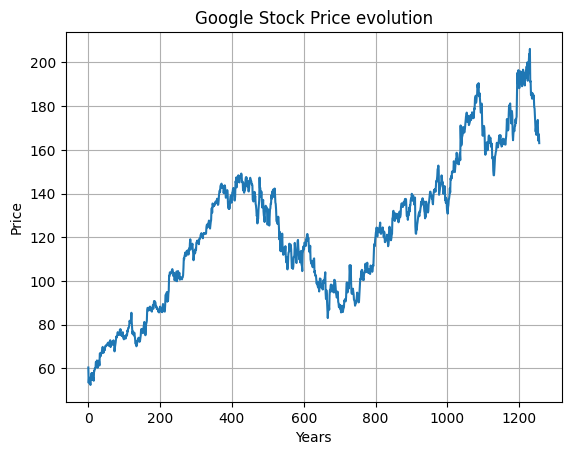

In [5]:
plt.plot(df.index, df['Close'])
plt.title("Google Stock Price evolution")
plt.xlabel("Years")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [6]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 50
lstm_df = prepare_dataframe_for_lstm(df, lookback)
lstm_df

Price,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-41),Close(t-42),Close(t-43),Close(t-44),Close(t-45),Close(t-46),Close(t-47),Close(t-48),Close(t-49),Close(t-50)
Ticker,GOOGL,,,,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-26,70.730339,70.325783,70.002823,70.122749,68.393021,68.929451,68.326332,67.520187,67.095711,68.431831,...,57.869328,54.818916,56.231663,52.455711,53.156361,55.319019,54.299900,55.637005,53.394726,60.424614
2020-05-27,70.676109,70.730339,70.325783,70.002823,70.122749,68.393021,68.929451,68.326332,67.520187,67.095711,...,55.248863,57.869328,54.818916,56.231663,52.455711,53.156361,55.319019,54.299900,55.637005,53.394726
2020-05-28,70.574585,70.676109,70.730339,70.325783,70.002823,70.122749,68.393021,68.929451,68.326332,67.520187,...,57.042782,55.248863,57.869328,54.818916,56.231663,52.455711,53.156361,55.319019,54.299900,55.637005
2020-05-29,71.334946,70.574585,70.676109,70.730339,70.325783,70.002823,70.122749,68.393021,68.929451,68.326332,...,57.821060,57.042782,55.248863,57.869328,54.818916,56.231663,52.455711,53.156361,55.319019,54.299900
2020-06-01,71.402122,71.334946,70.574585,70.676109,70.730339,70.325783,70.002823,70.122749,68.393021,68.929451,...,54.842796,57.821060,57.042782,55.248863,57.869328,54.818916,56.231663,52.455711,53.156361,55.319019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-07,173.660004,172.151733,172.820969,170.723373,166.817871,170.084106,168.306168,172.531296,175.218201,179.043793,...,196.643524,191.569366,189.212082,189.082245,191.020004,192.538254,195.375000,195.884399,194.406113,191.189804
2025-03-10,165.869995,173.660004,172.151733,172.820969,170.723373,166.817871,170.084106,168.306168,172.531296,175.218201,...,195.265121,196.643524,191.569366,189.212082,189.082245,191.020004,192.538254,195.375000,195.884399,194.406113


In [7]:
lstm_df_np = lstm_df.to_numpy()

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
lstm_df_np = scaler.fit_transform(lstm_df_np)

lstm_df_np

array([[-0.95767659, -0.96352532, -0.9681944 , ..., -0.95580864,
        -0.98695615, -0.88930394],
       [-0.95846059, -0.95767659, -0.96352532, ..., -0.97438237,
        -0.95580864, -0.98695615],
       [-0.95992835, -0.95846059, -0.95767659, ..., -0.96022578,
        -0.97438237, -0.95580864],
       ...,
       [ 0.39131599,  0.41777262,  0.53039401, ...,  0.94588727,
         0.98529253,  0.9923686 ],
       [ 0.43569957,  0.39131599,  0.41777262, ...,  0.92479726,
         0.94588727,  0.98529253],
       [ 0.37700354,  0.43569957,  0.39131599, ...,  0.89787983,
         0.92479726,  0.94588727]])

In [9]:
X = lstm_df_np[:, 1:]
y = lstm_df_np[:, 0]
X = dc(np.flip(X, axis=1))
split_index = int(len(X) * 0.95)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [10]:
# Transfer data to torch tensors

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [12]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
device = 'cpu'

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 50, 1]) torch.Size([16, 1])


In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
def train_one_epoch():
    model.train(True)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.6f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0


In [16]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    if (epoch + 1) % 10 == 0:
        print('Val Loss: {0:.6f}'.format(avg_loss_across_batches))
    return avg_loss_across_batches

In [17]:
loss_tracking = []
lr = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_one_epoch()
    loss = validate_one_epoch()
    loss_tracking.append(loss)
    

Epoch: 10
Val Loss: 0.053576


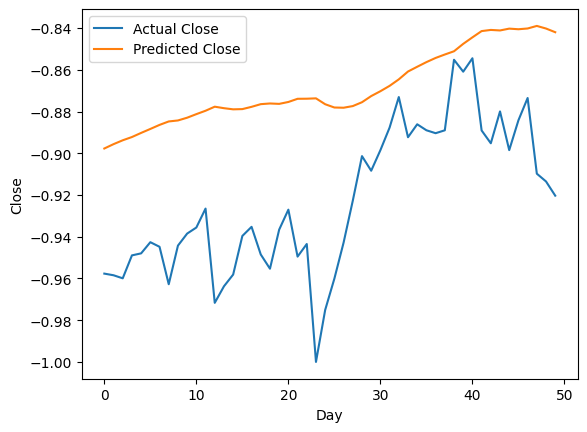

In [18]:

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:50], label='Actual Close')
plt.plot(predicted[:50], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [19]:
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_one_epoch()
    loss = validate_one_epoch()
    loss_tracking.append(loss)

Epoch: 10
Val Loss: 0.012545
Epoch: 20
Val Loss: 0.007946
Epoch: 30
Val Loss: 0.005789
Epoch: 40
Val Loss: 0.004404
Epoch: 50
Val Loss: 0.003667
Epoch: 60
Val Loss: 0.003654
Epoch: 70
Val Loss: 0.003261
Epoch: 80
Val Loss: 0.003179
Epoch: 90
Val Loss: 0.003189
Epoch: 100
Val Loss: 0.003368


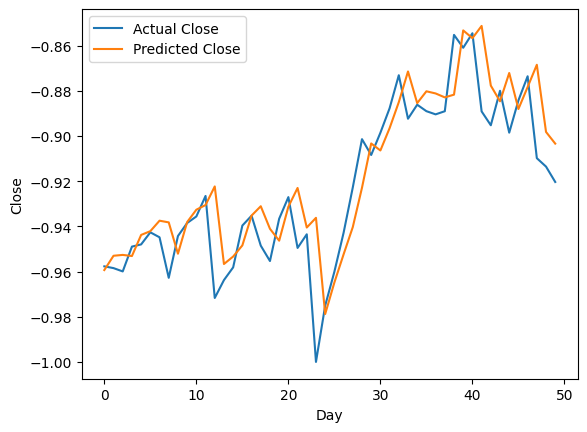

In [20]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:50], label='Actual Close')
plt.plot(predicted[:50], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

Epoch: 10
Val Loss: 0.003218
Epoch: 20
Val Loss: 0.003150
Epoch: 30
Val Loss: 0.003265
Epoch: 40
Val Loss: 0.003163
Epoch: 50
Val Loss: 0.003286
Epoch: 60
Val Loss: 0.003071
Epoch: 70
Val Loss: 0.003217
Epoch: 80
Val Loss: 0.003250
Epoch: 90
Val Loss: 0.003227
Epoch: 100
Val Loss: 0.003310
Epoch: 110
Val Loss: 0.003098
Epoch: 120
Val Loss: 0.003145
Epoch: 130
Val Loss: 0.003116
Epoch: 140
Val Loss: 0.003095
Epoch: 150
Val Loss: 0.003253
Epoch: 160
Val Loss: 0.003133
Epoch: 170
Val Loss: 0.003317
Epoch: 180
Val Loss: 0.003186
Epoch: 190
Val Loss: 0.003213
Epoch: 200
Val Loss: 0.003202
Epoch: 210
Val Loss: 0.003370
Epoch: 220
Val Loss: 0.003133
Epoch: 230
Val Loss: 0.003188
Epoch: 240
Val Loss: 0.003227
Epoch: 250
Val Loss: 0.003427
Epoch: 260
Val Loss: 0.003195
Epoch: 270
Val Loss: 0.003303
Epoch: 280
Val Loss: 0.003654
Epoch: 290
Val Loss: 0.003225
Epoch: 300
Val Loss: 0.003366


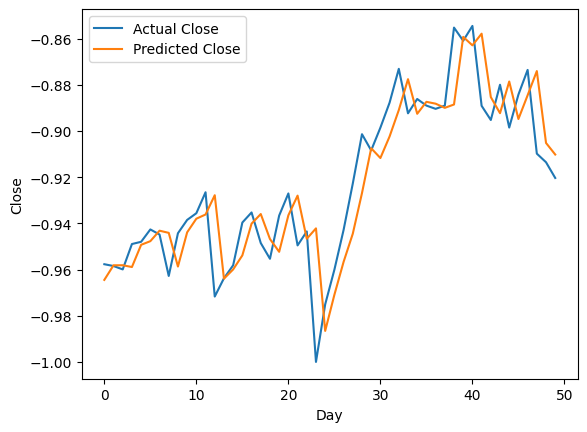

In [21]:
num_epochs = 300

for epoch in range(num_epochs):
    train_one_epoch()
    loss = validate_one_epoch()
    loss_tracking.append(loss)

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:50], label='Actual Close')
plt.plot(predicted[:50], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

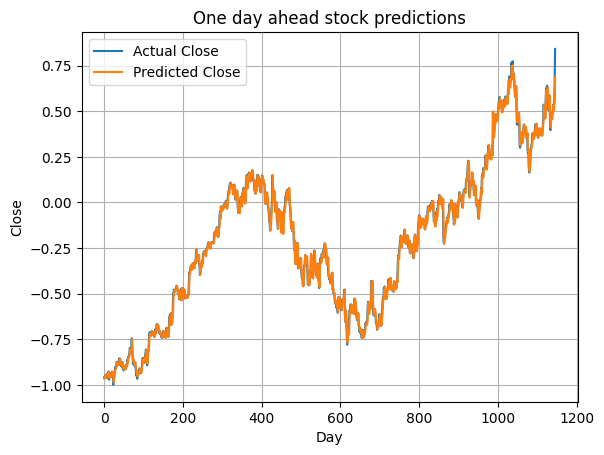

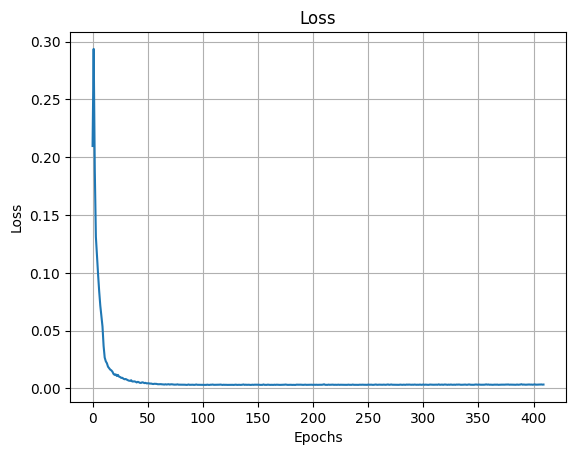

In [24]:
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.title("One day ahead stock predictions")
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

plt.plot(loss_tracking)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()